Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We will explore the dataset of GD153 F098M in PID 11552. There are three files: iab9a1ewq, iab901eiq, and iab901eqq. We had evidence of about 0.5 mag fluctuation across the three, which is obviously unusual. We would like to investigate more whether this is a problem from observation or from the reduction.

# Previously
20200820, 03_hstphot_pipeline_continued.ipynb, developed HSTPHOT 1.2.0 flow. The dataset mentioned was used as a test case, and that was where we found this unusual behaviour. We suspected that this might be due to bad drizzling, or the effect of location on the chip.

# Task
- Explore flt files
- Explore drz files
- Test with other datasets
- ...


In [1]:
from hstphot.read_ds9region import read_ds9region
from hstphot.container import Container
from hstphot.cutout2d import Cutout2d
from hstphot.objectmask import ObjectMask
from hstphot.background import Background
from hstphot.apphot import ApPhot
from hstphot.phot2abmag import Phot2ABmag
from hstphot.mag2flux import mag2flux
from hstphot.to_fullframe import to_fullframe
from hstphot.show_source import show_source
from hstphot.show_sum1d import show_sum1d
from mag2flux.mag2flux import mag2flux
from drizzlepac.astrodrizzle import AstroDrizzle
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,copy

tp = '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST'
t = glob.glob(tp + '/*/*flt.fits')
filelist = []
for i,ii in enumerate(t):
    th = fits.open(ii)[0].header
#     print('{0} {1} {2} {3}'.format(i,th['ROOTNAME'],th['FILTER'],th['SUBARRAY']))
    if th['FILTER'] in {'F098M'}:
        filelist.append((th['ROOTNAME'],th['FILTER'],ii))
filelist


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


[('iab901eqq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901eqq/iab901eqq_flt.fits'),
 ('iab901eiq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901eiq/iab901eiq_flt.fits'),
 ('iab9a1ewq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab9a1ewq/iab9a1ewq_flt.fits')]

# 1. Test with new drz files downloaded directly from MAST

In [2]:
t = []
for i in filelist:
    string = '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/new_drz_flt/{0}/{0}_drz.fits'.format(i[0])
    t.append((i[0],i[1],string))
drzlist = copy.deepcopy(t)
drzlist


[('iab901eqq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/new_drz_flt/iab901eqq/iab901eqq_drz.fits'),
 ('iab901eiq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/new_drz_flt/iab901eiq/iab901eiq_drz.fits'),
 ('iab9a1ewq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/new_drz_flt/iab9a1ewq/iab9a1ewq_drz.fits')]

In [3]:
t = []
for ii,i in enumerate(drzlist):
    string = '../20200819/ds9_{0}.reg'.format(i[0])
    t.append(string)
ds9list = copy.deepcopy(t)
ds9list


['../20200819/ds9_iab901eqq.reg',
 '../20200819/ds9_iab901eiq.reg',
 '../20200819/ds9_iab9a1ewq.reg']

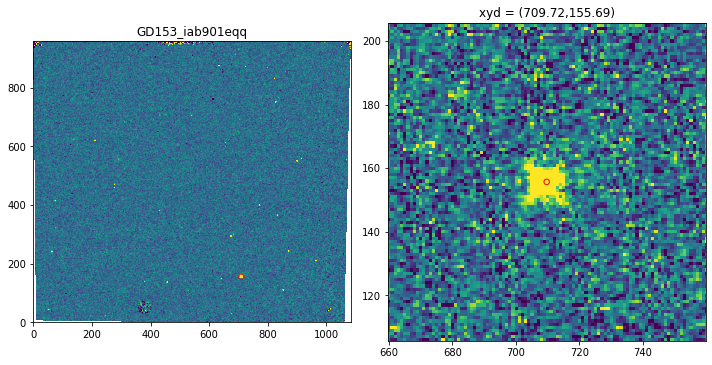

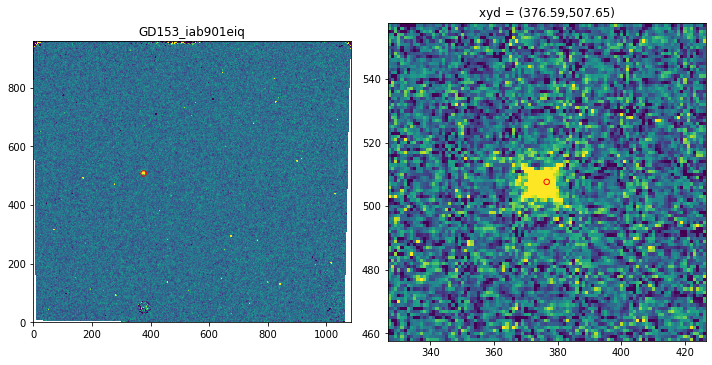

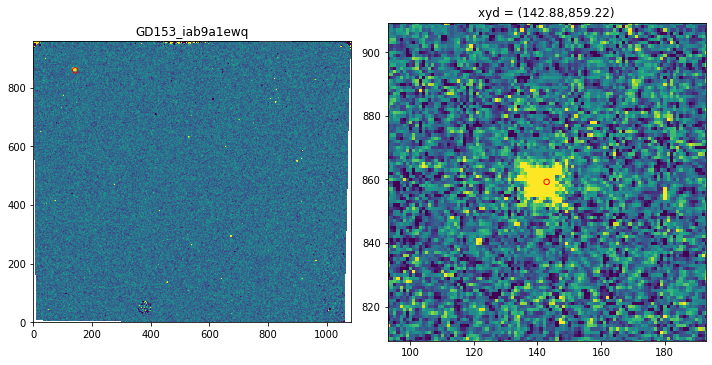

In [4]:
for ii,i in enumerate(drzlist):
    dfile = (i[2],1)
    xyd = read_ds9region(ds9list[ii])['GD153']
    title = 'GD153_{0}'.format(i[0])
    show_source(dfile,xyd,title)
    

In [5]:
aperture_radius = 5
apphot = []
for ii,i in enumerate(drzlist):
    th = fits.open(i[2])[0].header
    effgain = th['EXPTIME']
    data = fits.open(i[2])[1].data
    ebkg = 0.
    center = read_ds9region(ds9list[ii])['GD153']
    t = ApPhot(data,ebkg,effgain,center,aperture_radius)
    t.compute()
    tc = Container(i[0],i[0],'pdf',False)
    apphot.append(t.apphot['phot_table'])


In [6]:
for ii,i in enumerate(drzlist):
    print(i[0],'\n',apphot[ii])
    print('###############\n')

iab901eqq 
  id  xcenter   ycenter     aperture_sum     aperture_sum_err
       pix       pix                                        
--- --------- --------- ------------------ -----------------
  1 709.71704 155.68579 26755.153192350313 67.54403896599011
###############

iab901eiq 
  id  xcenter   ycenter     aperture_sum     aperture_sum_err
       pix       pix                                        
--- --------- --------- ------------------ -----------------
  1 376.58542 507.65314 26355.746165674427 67.03816627948399
###############

iab9a1ewq 
  id  xcenter   ycenter     aperture_sum     aperture_sum_err
       pix       pix                                        
--- --------- --------- ------------------ -----------------
  1 142.87794 859.21781 26575.079431022765 67.31607011380697
###############



In [7]:
instrument = 'HST-WFC3-IR'
abmag = []
for ii,i in enumerate(drzlist):
    filterobs = i[1]
    t = pd.read_csv('./{0}/{0}_apphot.csv'.format(i[0]))
    aperture_radius = aperture_radius
    cps = apphot[ii]['aperture_sum']
    error = apphot[ii]['aperture_sum_err']
    t = Phot2ABmag(instrument,filterobs,aperture_radius,cps,error)
    t.compute()
    abmag.append(t)
    

In [8]:
for ii,i in enumerate(drzlist):
    tm = abmag[ii].mag[0][0]
    te = abmag[ii].mag[1][0]
    tw = abmag[ii].wavelength
    t = mag2flux(tm,te,tw)
    print(t)
    

(1.771613395695178e-15, 4.472481371017462e-18)
(1.7451663470198675e-15, 4.438984615402323e-18)
(1.759689670740686e-15, 4.457386235159903e-18)


# Summary
We concluded that the problem was dued to bad drizzling.
